In [1]:
import zipfile
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
from io import TextIOWrapper
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

def read_md_files_from_zip(zip_path):
    data = []
    with zipfile.ZipFile(zip_path) as z:
        for file_info in z.infolist():
            if file_info.filename.endswith('.md'):
                with z.open(file_info) as file:
                    content = TextIOWrapper(file, encoding='utf-8').read()
                    data.append({'filename': file_info.filename, 'content': content})
    return pd.DataFrame(data)

In [2]:
zip_path = './Parsed.zip'
df = read_md_files_from_zip(zip_path)

In [3]:
df['filename'] = df['filename'].str.replace('Parsed/', '', regex=False)

In [4]:
df.head()

,filename,content
0,Software Engineer FINBOURNE Technology.md,## \n About the job\n\nFINBOURNE ...
1,".Net Solution Developer | SEB Life, Stockholm ...",## \n About the job\n\nAt SEB Lif...
2,"Software Developer, IT Application Tesla.md",## \n About the job\n\n**What To ...
3,Software Engineer - Card Processing and Author...,## \n About the job\n\n**Company ...
4,Software Engineer - .NET | Azure (f|m|d) E.ON.md,## \n About the job\n\n**Responsi...


In [5]:
import re

def clean_markdown(text):
    text = re.sub(r'#+ ', '', text)
    text = re.sub(r'\*\*|\*|_', '', text)
    text = re.sub(r'^- ', '', text, flags=re.MULTILINE)
    text = re.sub(r'^> ', '', text, flags=re.MULTILINE)
    text = re.sub(r'\[([^\]]+)\]\([^)]+\)', r'\1', text)
    text = re.sub(r'!\[[^\]]*\]\([^)]+\)', '', text)
    return text
def clean_html(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)
def clean_special_characters_and_numbers(text):
    return re.sub(r'[^a-zA-Zа-яА-Я\s]', '', text)
df['content_cleaned'] = df['content'].apply(clean_markdown)
df['content_cleaned'] = df['content_cleaned'].apply(clean_html)
df['content_cleaned'] = df['content_cleaned'].apply(clean_special_characters_and_numbers)


In [6]:
df = df.drop("content",axis=1)

In [7]:
df.head()

,filename,content_cleaned
0,Software Engineer FINBOURNE Technology.md,\n About the job\n\nFINBOURNE Hor...
1,".Net Solution Developer | SEB Life, Stockholm ...",\n About the job\n\nAt SEB Life ...
2,"Software Developer, IT Application Tesla.md",\n About the job\n\nWhat To Expec...
3,Software Engineer - Card Processing and Author...,\n About the job\n\nCompany Descr...
4,Software Engineer - .NET | Azure (f|m|d) E.ON.md,\n About the job\n\nResponsibilit...


In [8]:
nltk.download('punkt')
nltk.download('stopwords')

def tokenize_text(text):
    return word_tokenize(text)

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [token for token in tokens if token not in stop_words]


df['tokens'] = df['content_cleaned'].apply(tokenize_text)
df['tokens'] = df['tokens'].apply(remove_stopwords)



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Александр\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Александр\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
df.head()

,filename,content_cleaned,tokens
0,Software Engineer FINBOURNE Technology.md,\n About the job\n\nFINBOURNE Hor...,"[About, job, FINBOURNE, Horizon, suite, partne..."
1,".Net Solution Developer | SEB Life, Stockholm ...",\n About the job\n\nAt SEB Life ...,"[About, job, At, SEB, Life, Pension, aim, best..."
2,"Software Developer, IT Application Tesla.md",\n About the job\n\nWhat To Expec...,"[About, job, What, To, Expect, In, position, S..."
3,Software Engineer - Card Processing and Author...,\n About the job\n\nCompany Descr...,"[About, job, Company, Description, Checkoutcom..."
4,Software Engineer - .NET | Azure (f|m|d) E.ON.md,\n About the job\n\nResponsibilit...,"[About, job, Responsibilities, Job, descriptio..."


In [24]:
df['text_for_tfidf'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text_for_tfidf'])

mean_tfidf = tfidf_matrix.mean(axis=0)
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = zip(feature_names, mean_tfidf.A.flatten())
sorted_tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)

important_words = sorted_tfidf_scores[:100]

num_clusters = 8
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(tfidf_matrix)
clusters = kmeans.labels_


df['cluster'] = clusters

important_words, df[['filename', 'cluster']].head()

([('experience', 0.0788305735755216),
  ('we', 0.07704775264366535),
  ('team', 0.06332944298755802),
  ('work', 0.060317275560927835),
  ('you', 0.051981037177953084),
  ('software', 0.04594453459916117),
  ('development', 0.04405456167768242),
  ('working', 0.04078778607980888),
  ('people', 0.03389072792184207),
  ('systems', 0.03374893158955285),
  ('our', 0.032935340868503395),
  ('data', 0.03265454909297725),
  ('teams', 0.03208355673989745),
  ('services', 0.03131547026541698),
  ('business', 0.030207438368874632),
  ('us', 0.030113509476762616),
  ('design', 0.02923353490469736),
  ('role', 0.02836059974639367),
  ('product', 0.028298193165618893),
  ('best', 0.028248652617705153),
  ('new', 0.02806062039891887),
  ('backend', 0.02759676476901936),
  ('company', 0.027495098321005277),
  ('engineers', 0.026854096548760482),
  ('solutions', 0.026838134856781163),
  ('the', 0.026427140448316302),
  ('make', 0.025885197203653208),
  ('process', 0.02570607284905413),
  ('engineering

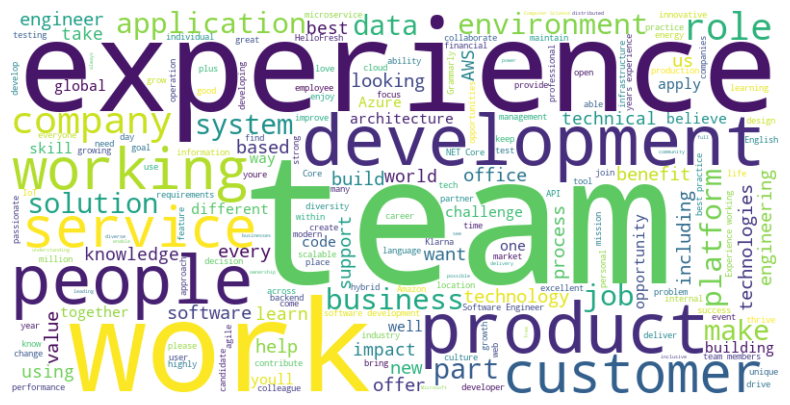

(1,
 {'Experience': 18,
  'We': 16,
  'work': 12,
  'developing': 12,
  'DeepL': 12,
  'products': 10,
  'team': 10,
  'services': 10,
  'new': 6,
  'best': 6,
  'worlds': 6,
  'Core': 6,
  'people': 6,
  'You': 6,
  'development': 6,
  'experience': 6,
  'software': 6,
  'What': 6,
  'highly': 4,
  'maintain': 4,
  'production': 4,
  'Strong': 4,
  'exciting': 4,
  'quality': 4,
  'office': 4,
  'efficient': 4,
  'remote': 4,
  'together': 4,
  'way': 4,
  'working': 4,
  'also': 4,
  'positive': 4,
  'years': 4,
  'NET': 4,
  'open': 4,
  'About': 4,
  'closer': 4,
  'develop': 4,
  'cultures': 4,
  'made': 4,
  'businesses': 4,
  'language': 4,
  'help': 4,
  'Our': 4,
  'neural': 4,
  'expressive': 4,
  'value': 4,
  'networks': 4,
  'barriers': 4,
  'company': 4,
  'offer': 4,
  'bring': 4,
  'reviews': 2,
  'strings': 2,
  'attached': 2,
  'reviewed': 2,
  'forever': 2,
  'communication': 2,
  'Work': 2,
  'Code': 2,
  'Urban': 2,
  'abroad': 2,
  'different': 2,
  'personal': 2,

In [25]:
all_words = ' '.join(df['text_for_tfidf'])
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

word_freq_by_cluster = []

for cluster_num in range(num_clusters):
    cluster_texts = df[df['cluster'] == cluster_num]['text_for_tfidf']
    cluster_words = ' '.join(cluster_texts)
    word_freq = pd.value_counts(cluster_words.split()).to_dict()
    word_freq_by_cluster.append((cluster_num, word_freq))

word_freq_by_cluster[1]

In [26]:
word_count_dict = {}
for num, words_dict in word_freq_by_cluster:
     for word, count in words_dict.items():
        if count > 2:  
             word_count_dict[word] = word_count_dict.get(word, 0) + count
sorted_words_with_counts = sorted(word_count_dict.items(), key=lambda x: x[1], reverse=True)


# Создание списка списков с проверкой на количество слов
sorted_words_with_counts_list = [[word, count] for word, count in sorted_words_with_counts if count > 2]

print(sorted_words_with_counts_list)




[['We', 221], ['team', 178], ['work', 153], ['experience', 132], ['You', 112], ['development', 104], ['software', 97], ['working', 92], ['Experience', 90], ['Our', 85], ['teams', 74], ['best', 65], ['About', 64], ['people', 64], ['The', 62], ['new', 62], ['job', 60], ['us', 58], ['data', 57], ['company', 57], ['services', 57], ['make', 53], ['solutions', 52], ['including', 51], ['environment', 50], ['business', 50], ['product', 49], ['design', 49], ['systems', 47], ['every', 47], ['build', 46], ['What', 45], ['role', 44], ['architecture', 44], ['part', 44], ['technology', 44], ['customers', 43], ['technologies', 42], ['also', 41], ['looking', 39], ['support', 39], ['skills', 38], ['engineering', 38], ['platform', 38], ['one', 38], ['based', 38], ['engineers', 37], ['years', 37], ['applications', 37], ['help', 37], ['developing', 36], ['process', 36], ['As', 35], ['want', 35], ['AWS', 34], ['opportunity', 34], ['backend', 34], ['code', 34], ['offer', 34], ['Azure', 34], ['like', 33], ['

In [27]:
skills_list = ['C#', '.NET', 'Framework', '.NET', 'Core', 'ASP.NET', 'MVC/WebAPI', 'Entity', 'Framework', 'SQL', 'LINQ', 'JavaScript', 'HTML/CSS', 'RESTful', 'API', 'Unit', 'Testing', 'Dependency', 'Injection', 'Git', 'OOP', 'SOLID', 'principles', 'Architectural', 'patterns', 'Experience', 'with', 'databases', 'Knowledge', 'of', 'algorithms', 'and', 'data', 'structures', 'Experience', 'with', 'Docker', 'Experience', 'with', 'cloud', 'platforms', 'Build', 'and', 'deployment', 'automation']
for i in sorted_words_with_counts_list:
    if i[0] in skills_list:     
        print(i)

['Experience', 90]
['data', 57]
['cloud', 20]
['Core', 18]
['patterns', 14]
['SQL', 12]
['platforms', 11]
['databases', 10]
['Docker', 10]
['Knowledge', 10]
['principles', 10]
['deployment', 9]
['Framework', 3]
['Unit', 3]
['algorithms', 3]
